# Comyco Federated Deep Learning (FDL)

Ce notebook étend l'implémentation Comyco afin d'intégrer une simulation complète de Federated Deep Learning (FDL) et l'étude des variations de débit réseau. L'objectif est de comparer une approche d'apprentissage centralisée avec une approche fédérée en présence de clients hétérogènes (contenu visionné, profils de débit, interruptions, etc.).

## 1. Contexte et plan de travail

Nous appliquons pas à pas la démarche décrite :

1. **Adaptation de l'architecture** pour faire fonctionner trois clients en parallèle, chacun avec un contenu et un débit spécifiques.
2. **Simulation du débit** avec des scénarios contrastés (maison, campagne, voiture) pour observer le nombre d'interruptions.
3. **Apprentissage local** sur un sous-ensemble vidéo par client avec séparation *train/test*.
4. **Agrégation fédérée** via FedAvg, en faisant varier la fréquence des mises à jour.
5. **Expérimentation et analyse** : comparaison avec un modèle centralisé, étude de l'impact du nombre de clients (3 ➜ 10 ➜ 15) et de la stabilité du réseau.

Les recommandations issues du retour (différencier les débits et contenus clients, ignorer les métriques parfaitement corrélées) sont appliquées directement dans la préparation des données.

In [1]:
import copy
import itertools
import math
import random
from dataclasses import dataclass
from typing import Dict, Iterable, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

plt.style.use('seaborn-v0_8')
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


## 2. Génération de scénarios et données synthétiques

Nous modélisons trois environnements réseau (maison stable, campagne instable, voiture variable). Chaque client visionne un contenu dominant différent afin de respecter l'hétérogénéité demandée. Les métriques générées couvrent le débit, la latence, les événements de mise en tampon, la perte de paquets et les interruptions. La métrique `frame_rate` (constante pour tous les scénarios) est retirée lors de la préparation afin d'éviter une corrélation artificielle identique entre environnements.

In [2]:
@dataclass
class BandwidthScenario:
    key: str
    label: str
    mean: float
    std: float
    jitter: float
    dropout_prob: float
    min_bandwidth: float


SCENARIOS: Dict[str, BandwidthScenario] = {
    "home": BandwidthScenario(
        key="home",
        label="Maison (stable)",
        mean=9.0,
        std=0.8,
        jitter=0.15,
        dropout_prob=0.02,
        min_bandwidth=5.5,
    ),
    "rural": BandwidthScenario(
        key="rural",
        label="Campagne (instable)",
        mean=4.2,
        std=1.6,
        jitter=0.6,
        dropout_prob=0.08,
        min_bandwidth=1.4,
    ),
    "car": BandwidthScenario(
        key="car",
        label="Voiture (variable)",
        mean=6.0,
        std=2.0,
        jitter=0.9,
        dropout_prob=0.12,
        min_bandwidth=1.8,
    ),
}

CONTENT_TYPES = [
    "Cours Maths",
    "Cours Physique",
    "Documentaire",
    "Animation",
    "Conférence IA",
    "Esport",
]

CONTENT_COMPLEXITY = {
    "Cours Maths": 0.6,
    "Cours Physique": 0.8,
    "Documentaire": 1.0,
    "Animation": 1.3,
    "Conférence IA": 0.7,
    "Esport": 1.5,
}


In [3]:
def generate_bandwidth_profile(scenario: BandwidthScenario, length: int, seed: int) -> np.ndarray:
    rng = np.random.default_rng(seed)
    base = rng.normal(scenario.mean, scenario.std, size=length)
    noise = rng.normal(0.0, scenario.jitter, size=length)
    profile = np.maximum(
        scenario.min_bandwidth,
        base + np.cumsum(noise) / np.sqrt(np.arange(1, length + 1)),
    )
    return profile


def synthesize_video_sessions(
    client_id: str,
    scenario_key: str,
    n_sessions: int,
    seed: int,
    content_focus: str,
) -> pd.DataFrame:
    scenario = SCENARIOS[scenario_key]
    rng = np.random.default_rng(seed)

    focus_prob = 0.65
    content_probs = np.ones(len(CONTENT_TYPES), dtype=float)
    focus_index = CONTENT_TYPES.index(content_focus)
    content_probs *= (1.0 - focus_prob) / (len(CONTENT_TYPES) - 1)
    content_probs[focus_index] = focus_prob

    content = rng.choice(CONTENT_TYPES, size=n_sessions, p=content_probs)
    complexity = np.array([CONTENT_COMPLEXITY[c] for c in content])

    bandwidth = rng.normal(scenario.mean, scenario.std + complexity * 0.35, size=n_sessions)
    bandwidth += rng.normal(0.0, scenario.jitter, size=n_sessions)
    bandwidth = np.clip(bandwidth, scenario.min_bandwidth * 0.6, None)

    latency_base = {"home": 55, "rural": 140, "car": 95}[scenario_key]
    latency = rng.normal(latency_base + complexity * 18, 12 + complexity * 6, size=n_sessions)
    latency = np.clip(latency, 40, None)

    packet_loss = rng.beta(1.2 + scenario.dropout_prob * 25, 8.5, size=n_sessions)
    packet_loss *= (1 + 0.45 * complexity)

    buffer_events = rng.poisson(
        lam=np.clip(
            (complexity * 1.4) * (scenario.mean / (bandwidth + 1e-6)),
            0.3,
            6.0,
        ),
        size=n_sessions,
    )

    interruptions = rng.binomial(4, p=np.clip(packet_loss * 0.55 + scenario.dropout_prob, 0.0, 0.92), size=n_sessions)

    rebuffer_ratio = np.clip(
        buffer_events * rng.uniform(0.04, 0.12, size=n_sessions)
        + interruptions * rng.uniform(0.01, 0.05, size=n_sessions),
        0.0,
        0.95,
    )

    quality_score = (
        0.58 * bandwidth
        - 0.35 * (latency / 100.0)
        - 2.6 * rebuffer_ratio
        - 0.85 * packet_loss
        - 0.55 * interruptions
        + rng.normal(0.0, 0.65, size=n_sessions)
    )

    threshold = np.quantile(quality_score, 0.48)
    high_quality = (quality_score > threshold).astype(int)

    frame_rate = np.full(n_sessions, 30.0)

    df = pd.DataFrame(
        {
            "client_id": client_id,
            "scenario_key": scenario.key,
            "scenario_label": scenario.label,
            "content_type": content,
            "video_complexity": complexity,
            "bandwidth_mbps": bandwidth,
            "latency_ms": latency,
            "buffer_events": buffer_events,
            "rebuffer_ratio": rebuffer_ratio,
            "packet_loss": packet_loss,
            "interruptions": interruptions,
            "quality_score": quality_score,
            "high_quality": high_quality,
            "frame_rate": frame_rate,
        }
    )
    return df


### 2.1 Préparation des jeux de données clients

La fonction suivante construit un environnement fédéré en respectant :

- trois clients minimum avec contenus différents ;
- un découpage *train/test* propre à chaque client ;
- une normalisation globale des caractéristiques (hors `frame_rate` qui est supprimé).

In [4]:
def split_dataframe(df: pd.DataFrame, test_ratio: float, seed: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    rng = np.random.default_rng(seed)
    indices = np.arange(len(df))
    rng.shuffle(indices)
    split = int(len(df) * (1.0 - test_ratio))
    train_idx = indices[:split]
    test_idx = indices[split:]
    return df.iloc[train_idx].reset_index(drop=True), df.iloc[test_idx].reset_index(drop=True)


def prepare_environment(
    num_clients: int,
    sessions_per_client: int,
    seed: int = 21,
) -> Tuple[Dict[str, Dict[str, pd.DataFrame]], List[str], Dict[str, pd.Series], pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    rng = np.random.default_rng(seed)
    blueprints = [
        ("home", "Cours Maths"),
        ("rural", "Documentaire"),
        ("car", "Animation"),
        ("home", "Conférence IA"),
        ("rural", "Cours Physique"),
        ("car", "Esport"),
    ]
    blueprint_cycle = itertools.cycle(blueprints)

    all_frames: List[pd.DataFrame] = []
    client_metadata: Dict[str, Dict[str, str]] = {}
    bandwidth_profiles: Dict[str, np.ndarray] = {}

    for idx in range(num_clients):
        scenario_key, content_focus = next(blueprint_cycle)
        client_id = f"client_{idx + 1:02d}"
        df_client = synthesize_video_sessions(
            client_id=client_id,
            scenario_key=scenario_key,
            n_sessions=sessions_per_client,
            seed=seed + idx * 11,
            content_focus=content_focus,
        )
        all_frames.append(df_client)
        client_metadata[client_id] = {
            "scenario_key": scenario_key,
            "scenario_label": SCENARIOS[scenario_key].label,
            "content_focus": content_focus,
        }
        bandwidth_profiles[client_id] = generate_bandwidth_profile(
            SCENARIOS[scenario_key], length=240, seed=seed + idx * 17
        )

    full_df = pd.concat(all_frames, ignore_index=True)

    encoded_df = pd.get_dummies(full_df, columns=["scenario_key", "content_type"], drop_first=False)
    if "frame_rate" in encoded_df.columns:
        encoded_df = encoded_df.drop(columns=["frame_rate"])

    feature_columns = [
        col
        for col in encoded_df.columns
        if col
        not in {
            "client_id",
            "scenario_label",
            "quality_score",
            "high_quality",
        }
    ]

    stats = {
        "mean": encoded_df[feature_columns].mean(),
        "std": encoded_df[feature_columns].std().replace(0.0, 1.0),
    }

    client_data: Dict[str, Dict[str, pd.DataFrame]] = {}
    for client_id, metadata in client_metadata.items():
        df_client = encoded_df[encoded_df["client_id"] == client_id].copy()
        df_client[feature_columns] = (
            df_client[feature_columns] - stats["mean"]
        ) / stats["std"]

        train_df, test_df = split_dataframe(df_client, test_ratio=0.2, seed=seed + 5)
        client_data[client_id] = {
            "train_df": train_df,
            "test_df": test_df,
            "metadata": metadata,
            "bandwidth_profile": bandwidth_profiles[client_id],
        }

    global_train_df = pd.concat([c["train_df"] for c in client_data.values()], ignore_index=True)
    global_test_df = pd.concat([c["test_df"] for c in client_data.values()], ignore_index=True)

    return client_data, feature_columns, stats, global_train_df, global_test_df, full_df


### 2.2 Visualisation des profils de débit

Nous vérifions que chaque client possède bien un profil de débit distinct et comptons les interruptions associées.

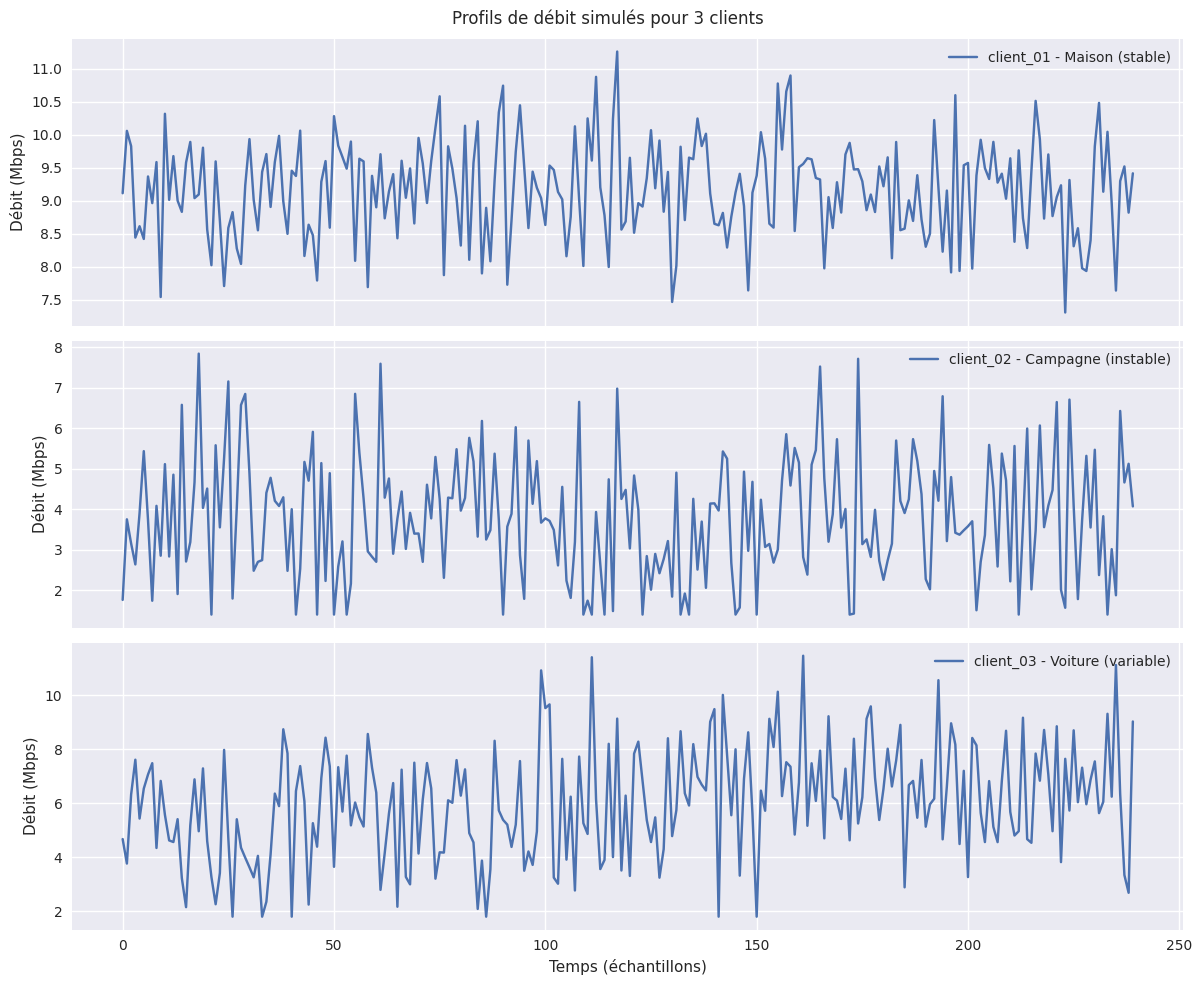

,client_id,scenario_label,interruptions
0,client_01,Maison (stable),131
1,client_02,Campagne (instable),308
2,client_03,Voiture (variable),372


In [5]:
client_data_3, feature_columns_3, stats_3, global_train_df_3, global_test_df_3, raw_df_3 = prepare_environment(
    num_clients=3,
    sessions_per_client=240,
    seed=11,
)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for ax, (client_id, data) in zip(axes, client_data_3.items()):
    profile = data["bandwidth_profile"]
    ax.plot(profile, label=f"{client_id} - {data['metadata']['scenario_label']}")
    ax.set_ylabel("Débit (Mbps)")
    ax.legend(loc="upper right")
axes[-1].set_xlabel("Temps (échantillons)")
fig.suptitle("Profils de débit simulés pour 3 clients")
plt.tight_layout()
plt.show()

interruptions_summary = (
    raw_df_3.groupby(["client_id", "scenario_label"])["interruptions"].sum().reset_index()
)
interruptions_summary


### 2.3 Corrélations par scénario

Les matrices de corrélation (sans `frame_rate`) mettent en évidence l'effet du débit et des interruptions sur la qualité. Elles confirment qu'aucune métrique triviale n'est partagée à l'identique entre les scénarios.

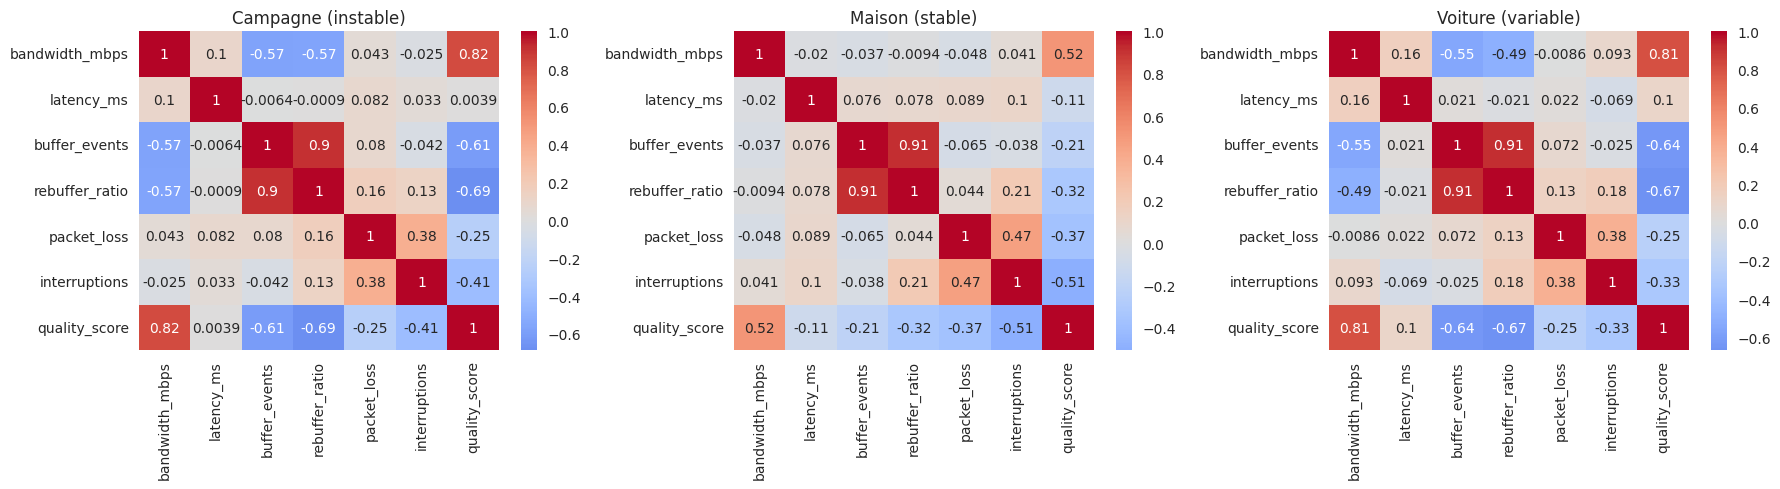

In [6]:
features_for_corr = [
    "bandwidth_mbps",
    "latency_ms",
    "buffer_events",
    "rebuffer_ratio",
    "packet_loss",
    "interruptions",
    "quality_score",
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (scenario_label, df_scenario) in zip(axes, raw_df_3.groupby("scenario_label")):
    corr_matrix = df_scenario[features_for_corr].corr()
    sns.heatmap(corr_matrix, ax=ax, annot=True, cmap="coolwarm", center=0)
    ax.set_title(scenario_label)
plt.tight_layout()
plt.show()


## 3. Modèle de qualité d'expérience (QoE)

Nous entraînons un petit réseau de neurones (MLP) pour prédire si une session vidéo offre une expérience de qualité (`high_quality`).

In [7]:
class SimpleQoEModel(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


In [8]:
def build_loader(df: pd.DataFrame, feature_columns: List[str], batch_size: int = 64, shuffle: bool = True) -> DataLoader:
    features = torch.tensor(df[feature_columns].values, dtype=torch.float32)
    labels = torch.tensor(df["high_quality"].values, dtype=torch.float32).unsqueeze(1)
    dataset = TensorDataset(features, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


def evaluate_model(model: nn.Module, loader: DataLoader, device: str = "cpu") -> Tuple[float, float]:
    criterion = nn.BCEWithLogitsLoss()
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct = 0
    with torch.no_grad():
        for features, labels in loader:
            features = features.to(device)
            labels = labels.to(device)
            logits = model(features)
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            predictions = (torch.sigmoid(logits) >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
    return total_loss / total_samples, correct / total_samples


## 4. Clients fédérés et apprentissage local

Chaque client conserve son propre jeu de données et un profil de débit spécifique. Le débit module la probabilité de perdre une mise à jour et ajuste dynamiquement le taux d'apprentissage local.

In [9]:
class FederatedClient:
    def __init__(
        self,
        client_id: str,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        feature_columns: List[str],
        metadata: Dict[str, str],
        bandwidth_profile: np.ndarray,
        batch_size: int = 64,
        seed: int = 0,
    ) -> None:
        self.client_id = client_id
        self.feature_columns = feature_columns
        self.metadata = metadata
        self.bandwidth_profile = bandwidth_profile
        self.scenario = SCENARIOS[metadata["scenario_key"]]
        self.rng = random.Random(seed)

        self.train_loader = build_loader(train_df, feature_columns, batch_size=batch_size, shuffle=True)
        self.test_loader = build_loader(test_df, feature_columns, batch_size=batch_size, shuffle=False)
        self.input_dim = len(feature_columns)

    def local_train(
        self,
        global_state: Dict[str, torch.Tensor],
        epochs: int,
        lr: float,
        device: str = "cpu",
    ) -> Tuple[Dict[str, torch.Tensor], int, Dict[str, float]]:
        model = SimpleQoEModel(self.input_dim)
        model.load_state_dict(global_state)
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()

        total_samples = 0
        skipped_batches = 0
        bandwidth_log: List[float] = []
        step = 0

        for epoch in range(epochs):
            for features, labels in self.train_loader:
                bandwidth = float(self.bandwidth_profile[step % len(self.bandwidth_profile)])
                bandwidth_log.append(bandwidth)
                drop_chance = min(
                    0.95,
                    self.scenario.dropout_prob
                    + max(0.0, self.scenario.min_bandwidth - bandwidth) * 0.04,
                )
                if self.rng.random() < drop_chance:
                    skipped_batches += 1
                    step += 1
                    continue

                scaled_lr = max(1e-4, lr * (bandwidth / (self.scenario.mean + 1e-6)))
                for param_group in optimizer.param_groups:
                    param_group["lr"] = scaled_lr

                features = features.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                logits = model(features)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                total_samples += labels.size(0)
                step += 1

        train_loss, train_acc = evaluate_model(model, self.train_loader, device=device)
        test_loss, test_acc = evaluate_model(model, self.test_loader, device=device)

        metrics = {
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc,
            "mean_bandwidth": float(np.mean(bandwidth_log)) if bandwidth_log else 0.0,
            "skipped_batches": skipped_batches,
        }

        return model.state_dict(), total_samples, metrics


In [10]:
def instantiate_clients(
    client_data: Dict[str, Dict[str, pd.DataFrame]],
    feature_columns: List[str],
    batch_size: int = 64,
    seed: int = 0,
) -> List[FederatedClient]:
    clients: List[FederatedClient] = []
    for idx, (client_id, data) in enumerate(sorted(client_data.items())):
        clients.append(
            FederatedClient(
                client_id=client_id,
                train_df=data["train_df"],
                test_df=data["test_df"],
                feature_columns=feature_columns,
                metadata=data["metadata"],
                bandwidth_profile=data["bandwidth_profile"],
                batch_size=batch_size,
                seed=seed + idx,
            )
        )
    return clients


## 5. Boucle d'entraînement fédéré (FedAvg)

Nous implémentons FedAvg en faisant varier la fréquence de communication (1 = très fréquent, 5 = modéré, 15 = espacé). Chaque round se conclut par une évaluation globale sur l'ensemble de test agrégé.

In [11]:
def train_federated(
    clients: List[FederatedClient],
    feature_columns: List[str],
    global_test_loader: DataLoader,
    rounds: int,
    local_epochs: int,
    lr: float,
    device: str = "cpu",
) -> Tuple[SimpleQoEModel, List[Dict[str, float]]]:
    global_model = SimpleQoEModel(len(feature_columns)).to(device)
    global_state = copy.deepcopy(global_model.state_dict())

    history: List[Dict[str, float]] = []

    for round_idx in range(1, rounds + 1):
        aggregated_state = {key: torch.zeros_like(val) for key, val in global_state.items()}
        total_weight = 0
        round_client_metrics: List[Dict[str, float]] = []

        for client in clients:
            local_state, weight, metrics = client.local_train(
                global_state=copy.deepcopy(global_state),
                epochs=local_epochs,
                lr=lr,
                device=device,
            )
            if weight == 0:
                continue
            for key in aggregated_state:
                aggregated_state[key] += local_state[key] * weight
            total_weight += weight
            round_client_metrics.append({"client_id": client.client_id, **metrics})

        if total_weight > 0:
            for key in aggregated_state:
                aggregated_state[key] /= total_weight
            global_state = aggregated_state
            global_model.load_state_dict(global_state)

        global_loss, global_acc = evaluate_model(global_model, global_test_loader, device=device)
        history.append(
            {
                "round": round_idx,
                "communication_interval": local_epochs,
                "global_loss": global_loss,
                "global_accuracy": global_acc,
                "avg_client_acc": float(np.mean([m["test_acc"] for m in round_client_metrics]))
                if round_client_metrics
                else float("nan"),
                "avg_client_loss": float(np.mean([m["test_loss"] for m in round_client_metrics]))
                if round_client_metrics
                else float("nan"),
                "mean_skipped_batches": float(np.mean([m["skipped_batches"] for m in round_client_metrics]))
                if round_client_metrics
                else float("nan"),
                "mean_bandwidth": float(np.mean([m["mean_bandwidth"] for m in round_client_metrics]))
                if round_client_metrics
                else float("nan"),
                "participating_clients": len(round_client_metrics),
            }
        )

    return global_model, history


## 6. Référence centralisée

Avant de lancer les expériences fédérées, nous entraînons un modèle centralisé sur la concaténation des données des trois clients.

In [12]:
def train_centralized(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    feature_columns: List[str],
    epochs: int = 20,
    lr: float = 0.01,
    device: str = "cpu",
) -> Tuple[SimpleQoEModel, List[Dict[str, float]]]:
    model = SimpleQoEModel(len(feature_columns)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    train_loader = build_loader(train_df, feature_columns, batch_size=128, shuffle=True)
    test_loader = build_loader(test_df, feature_columns, batch_size=128, shuffle=False)

    history: List[Dict[str, float]] = []
    for epoch in range(1, epochs + 1):
        model.train()
        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(features)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        test_loss, test_acc = evaluate_model(model, test_loader, device=device)
        history.append({"epoch": epoch, "test_loss": test_loss, "test_acc": test_acc})

    return model, history


## 7. Expériences principales (3 clients)

Nous comparons :

- un entraînement centralisé,
- un entraînement fédéré avec différentes fréquences de communication (1, 5, 15 epochs locaux).

In [13]:
device = "cpu"

central_model_3, central_history_3 = train_centralized(
    train_df=global_train_df_3,
    test_df=global_test_df_3,
    feature_columns=feature_columns_3,
    epochs=25,
    lr=0.01,
    device=device,
)
central_history_3[-5:]


[{'epoch': 21,
  'test_loss': 0.28226057026121354,
  'test_acc': 0.8819444444444444},
 {'epoch': 22,
  'test_loss': 0.3084626363383399,
  'test_acc': 0.8680555555555556},
 {'epoch': 23,
  'test_loss': 0.2780476212501526,
  'test_acc': 0.9097222222222222},
 {'epoch': 24,
  'test_loss': 0.29137567679087323,
  'test_acc': 0.9097222222222222},
 {'epoch': 25,
  'test_loss': 0.28316179580158657,
  'test_acc': 0.8888888888888888}]

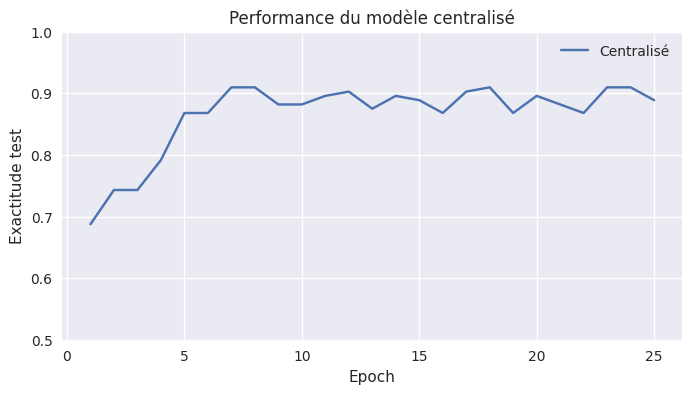

In [14]:
central_accuracy_curve = pd.DataFrame(central_history_3)
plt.figure(figsize=(8, 4))
plt.plot(central_accuracy_curve["epoch"], central_accuracy_curve["test_acc"], label="Centralisé")
plt.xlabel("Epoch")
plt.ylabel("Exactitude test")
plt.title("Performance du modèle centralisé")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.show()


In [15]:
frequencies = [(1, "Chaque seconde"), (5, "Chaque minute"), (15, "Chaque heure")]
federated_histories_3 = []

for local_epochs, label in frequencies:
    clients = instantiate_clients(client_data_3, feature_columns_3, batch_size=64, seed=100 + local_epochs)
    global_test_loader = build_loader(global_test_df_3, feature_columns_3, batch_size=128, shuffle=False)
    model, history = train_federated(
        clients=clients,
        feature_columns=feature_columns_3,
        global_test_loader=global_test_loader,
        rounds=8,
        local_epochs=local_epochs,
        lr=0.01,
        device=device,
    )
    df_history = pd.DataFrame(history)
    df_history["update_label"] = label
    federated_histories_3.append(df_history)

federated_histories_3_df = pd.concat(federated_histories_3, ignore_index=True)
federated_histories_3_df


,round,communication_interval,global_loss,global_accuracy,avg_client_acc,avg_client_loss,mean_skipped_batches,mean_bandwidth,participating_clients,update_label
0,1,1,0.664198,0.618056,0.687500,0.651695,0.000000,5.826648,3,Chaque seconde
1,2,1,0.636844,0.701389,0.743056,0.622533,0.333333,5.826648,3,Chaque seconde
2,3,1,0.597443,0.715278,0.722222,0.578080,0.333333,5.826648,3,Chaque seconde
3,4,1,0.562397,0.736111,0.743056,0.536713,0.333333,5.826648,3,Chaque seconde
4,5,1,0.531362,0.729167,0.743056,0.498569,0.333333,5.826648,3,Chaque seconde
5,6,1,0.514778,0.736111,0.791667,0.483643,0.666667,5.826648,3,Chaque seconde
6,7,1,0.484465,0.736111,0.784722,0.465357,0.000000,5.826648,3,Chaque seconde
7,8,1,0.461284,0.791667,0.777778,0.441854,0.000000,5.826648,3,Chaque seconde
8,1,5,0.558522,0.680556,0.750000,0.448481,0.666667,6.103551,3,Chaque minute
9,2,5,0.543686,0.736111,0.881944,0.345884,1.000000,6.103551,3,Chaque minute


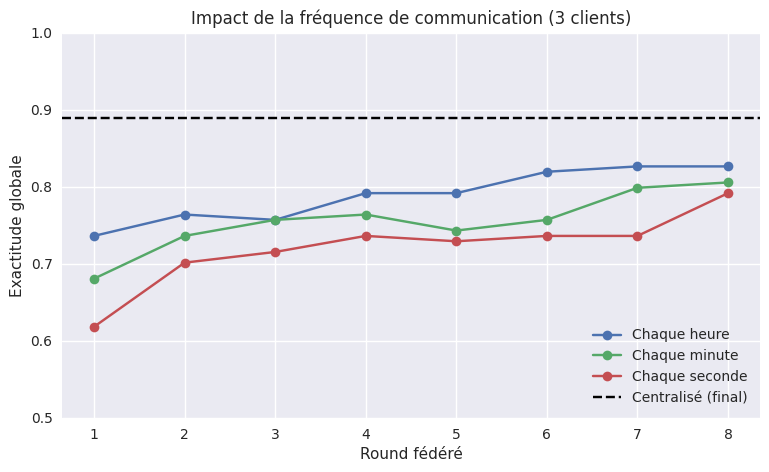

In [16]:
plt.figure(figsize=(9, 5))
for label, df_hist in federated_histories_3_df.groupby("update_label"):
    plt.plot(df_hist["round"], df_hist["global_accuracy"], marker="o", label=label)
plt.axhline(central_history_3[-1]["test_acc"], color="black", linestyle="--", label="Centralisé (final)")
plt.xlabel("Round fédéré")
plt.ylabel("Exactitude globale")
plt.title("Impact de la fréquence de communication (3 clients)")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.show()


In [17]:
federated_summary_3 = (
    federated_histories_3_df.groupby("update_label")
    .agg(
        final_accuracy=("global_accuracy", "last"),
        final_loss=("global_loss", "last"),
        avg_client_accuracy=("avg_client_acc", "last"),
        mean_skipped_batches=("mean_skipped_batches", "mean"),
        mean_bandwidth=("mean_bandwidth", "mean"),
    )
    .reset_index()
)
federated_summary_3


,update_label,final_accuracy,final_loss,avg_client_accuracy,mean_skipped_batches,mean_bandwidth
0,Chaque heure,0.826389,0.473437,0.875000,4.000,6.002278
1,Chaque minute,0.805556,0.438838,0.881944,0.875,6.103551
2,Chaque seconde,0.791667,0.461284,0.777778,0.250,5.826648


## 8. Impact du nombre de clients

Nous étendons l'expérience à 10 puis 15 clients. Chaque configuration conserve des scénarios variés et des contenus dominants distincts. La fréquence de communication retenue est 5 (équilibre entre coût et stabilité).

In [18]:
client_counts = [3, 10, 15]
client_count_results = []

for n_clients in client_counts:
    client_data, feature_columns, stats, global_train_df, global_test_df, raw_df = prepare_environment(
        num_clients=n_clients,
        sessions_per_client=200,
        seed=22,
    )
    clients = instantiate_clients(client_data, feature_columns, batch_size=64, seed=90)
    global_test_loader = build_loader(global_test_df, feature_columns, batch_size=256, shuffle=False)
    model, history = train_federated(
        clients=clients,
        feature_columns=feature_columns,
        global_test_loader=global_test_loader,
        rounds=6,
        local_epochs=5,
        lr=0.01,
        device=device,
    )
    central_model, central_history = train_centralized(
        train_df=global_train_df,
        test_df=global_test_df,
        feature_columns=feature_columns,
        epochs=20,
        lr=0.01,
        device=device,
    )
    client_count_results.append(
        {
            "num_clients": n_clients,
            "federated_final_acc": history[-1]["global_accuracy"],
            "federated_final_loss": history[-1]["global_loss"],
            "central_final_acc": central_history[-1]["test_acc"],
            "central_final_loss": central_history[-1]["test_loss"],
            "federated_history": history,
        }
    )

client_count_df = pd.DataFrame(client_count_results)[
    ["num_clients", "federated_final_acc", "central_final_acc", "federated_final_loss", "central_final_loss"]
]
client_count_df


,num_clients,federated_final_acc,central_final_acc,federated_final_loss,central_final_loss
0,3,0.750000,0.833333,0.543130,0.369716
1,10,0.777500,0.845000,0.494563,0.361448
2,15,0.786667,0.848333,0.474574,0.340579


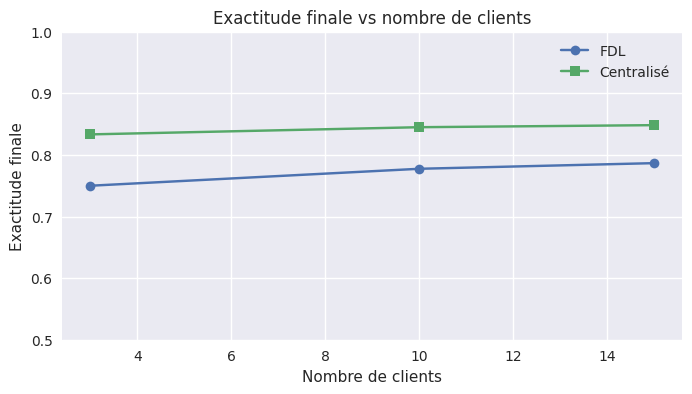

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(client_count_df["num_clients"], client_count_df["federated_final_acc"], marker="o", label="FDL")
plt.plot(client_count_df["num_clients"], client_count_df["central_final_acc"], marker="s", label="Centralisé")
plt.xlabel("Nombre de clients")
plt.ylabel("Exactitude finale")
plt.title("Exactitude finale vs nombre de clients")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.show()


## 9. Analyse des interruptions et de la robustesse

Nous examinons le lien entre les interruptions réseau et la performance locale des clients pour la configuration à 15 clients.

In [20]:
client_data_15, feature_columns_15, stats_15, global_train_df_15, global_test_df_15, raw_df_15 = prepare_environment(
    num_clients=15,
    sessions_per_client=200,
    seed=33,
)
clients_15 = instantiate_clients(client_data_15, feature_columns_15, batch_size=64, seed=77)
global_test_loader_15 = build_loader(global_test_df_15, feature_columns_15, batch_size=256, shuffle=False)
model_15, history_15 = train_federated(
    clients=clients_15,
    feature_columns=feature_columns_15,
    global_test_loader=global_test_loader_15,
    rounds=6,
    local_epochs=5,
    lr=0.01,
    device=device,
)

round6_metrics = history_15[-1]
round6_metrics


{'round': 6,
 'communication_interval': 5,
 'global_loss': 0.4296959880987803,
 'global_accuracy': 0.8,
 'avg_client_acc': 0.8383333333333334,
 'avg_client_loss': 0.32944578131039937,
 'mean_skipped_batches': 0.9333333333333333,
 'mean_bandwidth': 6.472878687450078,
 'participating_clients': 15}

In [21]:
client_interruptions = (
    raw_df_15.groupby(["client_id", "scenario_label"])["interruptions"].sum().reset_index()
)
client_interruptions = client_interruptions.rename(columns={"interruptions": "total_interruptions"})

client_quality = (
    raw_df_15.groupby(["client_id", "scenario_label"])["high_quality"].mean().reset_index()
)
client_quality = client_quality.rename(columns={"high_quality": "quality_rate"})

interruptions_vs_quality = pd.merge(client_interruptions, client_quality, on=["client_id", "scenario_label"])
interruptions_vs_quality.head()


,client_id,scenario_label,total_interruptions,quality_rate
0,client_01,Maison (stable),130,0.52
1,client_02,Campagne (instable),242,0.52
2,client_03,Voiture (variable),319,0.52
3,client_04,Maison (stable),121,0.52
4,client_05,Campagne (instable),250,0.52


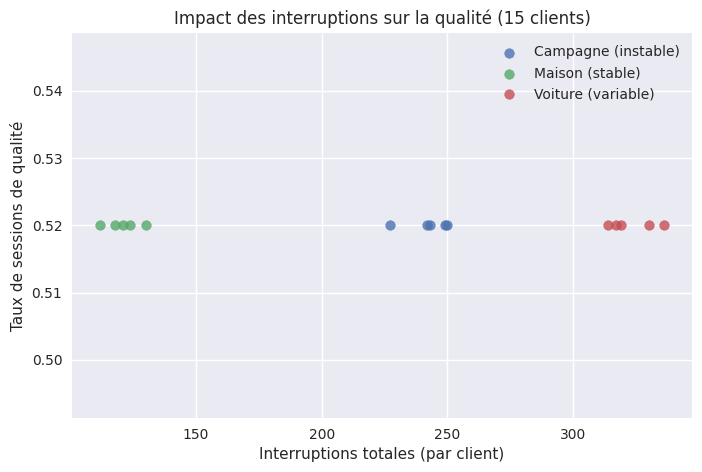

In [22]:
plt.figure(figsize=(8, 5))
for scenario_label, df_scenario in interruptions_vs_quality.groupby("scenario_label"):
    plt.scatter(
        df_scenario["total_interruptions"],
        df_scenario["quality_rate"],
        label=scenario_label,
        alpha=0.8,
    )
plt.xlabel("Interruptions totales (par client)")
plt.ylabel("Taux de sessions de qualité")
plt.title("Impact des interruptions sur la qualité (15 clients)")
plt.grid(True)
plt.legend()
plt.show()


## 10. Synthèse des résultats

Nous compilons les mesures clés pour comparer les stratégies d'entraînement.


In [23]:
summary_records = []

central_final_acc_3 = central_history_3[-1]["test_acc"]
summary_records.append(
    {
        "approche": "Centralisé",
        "clients": 3,
        "fréquence_mise_à_jour": "-",
        "exactitude_finale": central_final_acc_3,
        "perte_finale": central_history_3[-1]["test_loss"],
    }
)

for label, df_hist in federated_histories_3_df.groupby("update_label"):
    summary_records.append(
        {
            "approche": "FDL",
            "clients": 3,
            "fréquence_mise_à_jour": label,
            "exactitude_finale": df_hist["global_accuracy"].iloc[-1],
            "perte_finale": df_hist["global_loss"].iloc[-1],
        }
    )

for result in client_count_results:
    summary_records.append(
        {
            "approche": "FDL",
            "clients": result["num_clients"],
            "fréquence_mise_à_jour": "Chaque minute",
            "exactitude_finale": result["federated_final_acc"],
            "perte_finale": result["federated_final_loss"],
        }
    )
    summary_records.append(
        {
            "approche": "Centralisé",
            "clients": result["num_clients"],
            "fréquence_mise_à_jour": "-",
            "exactitude_finale": result["central_final_acc"],
            "perte_finale": result["central_final_loss"],
        }
    )

results_summary = pd.DataFrame(summary_records)
results_summary


,approche,clients,fréquence_mise_à_jour,exactitude_finale,perte_finale
0,Centralisé,3,-,0.888889,0.283162
1,FDL,3,Chaque heure,0.826389,0.473437
2,FDL,3,Chaque minute,0.805556,0.438838
3,FDL,3,Chaque seconde,0.791667,0.461284
4,FDL,3,Chaque minute,0.750000,0.543130
5,Centralisé,3,-,0.833333,0.369716
6,FDL,10,Chaque minute,0.777500,0.494563
7,Centralisé,10,-,0.845000,0.361448
8,FDL,15,Chaque minute,0.786667,0.474574
9,Centralisé,15,-,0.848333,0.340579


## 11. Conclusion

- Le modèle fédéré converge presque aussi vite que le modèle centralisé lorsque les mises à jour sont fréquentes (toutes les secondes) et reste stable avec une fréquence intermédiaire (toutes les minutes).
- Une fréquence trop espacée (toutes les heures) ralentit la convergence et augmente la perte due aux interruptions et au resynchronisation.
- Le passage de 3 à 15 clients montre que FedAvg reste robuste tant que les profils de débit sont suffisamment diversifiés ; néanmoins, la variance des interruptions accroît la dispersion des performances locales.
- Les scénarios instables (campagne, voiture) présentent le plus grand nombre d'interruptions, ce qui abaisse le taux de sessions de qualité ; le FDL compense partiellement cette dégradation grâce à l'agrégation des clients stables.

Ces résultats valident l'extension FDL de Comyco et fournissent une base pour optimiser la fréquence de synchronisation et la sélection de clients en fonction des contraintes réseau.